# EDAレポート
- 基本的にeda001とeda002をまとめたもの
- Kernelは一切見てないです  

## 目次
1. Import
2. Config
3. DataLoad
4. train、testに関する前提情報
5. featuresに対する考察
6. storesに関する考察
7. Store、Deptに関する考察
8. Weekly_Salesに関する考察
9. 分析結果まとめ

## Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from ptitprince import RainCloud
from pandarallel import pandarallel
from datetime import datetime as dt
import math
pandarallel.initialize()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Config

In [2]:
INPUT = '../input/'

## DataLoad

In [3]:
train = pd.read_csv(INPUT+'train.csv')
test = pd.read_csv(INPUT+'test.csv')
features = pd.read_csv(INPUT+'features.csv')
stores = pd.read_csv(INPUT+'stores.csv')
sample = pd.read_csv(INPUT+'sampleSubmission.csv')

In [4]:
#featuresとstoresをmerge
train_feat_df = pd.merge(train,features.drop(columns='IsHoliday'),how='left',on=['Store','Date'])
train_feat_df = pd.merge(train_feat_df,stores,how='left',on='Store')
test_feat_df = pd.merge(test,features.drop(columns='IsHoliday'),how='left',on=['Store','Date'])
test_feat_df = pd.merge(test_feat_df,stores,how='left',on='Store')

#timestamp型に直す
train['Date'] = train['Date'].parallel_apply(lambda x:dt.strptime(x,'%Y-%m-%d'))
test['Date'] = test['Date'].parallel_apply(lambda x:dt.strptime(x,'%Y-%m-%d'))

train['Year'] = train['Date'].dt.year
train['Week'] = train['Date'].dt.week
train['Month'] = train['Date'].dt.month
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['Week'] = test['Date'].dt.week

/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  app.launch_new_instance()


## train、testに関する前提情報
- trainは2010-2012までのデータ、testは2012-2013のデータ → 未来を予測するコンペ
- Dept、Store共に、unseenなものはない
    - それぞれのStoreのそれぞれのDeptの未来を予測する
- Weekly_Salesは毎週金曜に集計されている
- データ量がかなり多い

## featuresに対する考察
- すべての特徴量とWeekly_Salesの相関がかなり低い → ノイズになるため使わない

In [5]:
corr_mat = train_feat_df.corr()
display(corr_mat['Weekly_Sales'].sort_values())

Store          -0.085195
Unemployment   -0.025864
CPI            -0.020921
Temperature    -0.002312
Fuel_Price     -0.000120
IsHoliday       0.012774
MarkDown2       0.024130
MarkDown4       0.045414
MarkDown3       0.060385
MarkDown1       0.085251
MarkDown5       0.090362
Dept            0.148032
Size            0.243828
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

<AxesSubplot:>

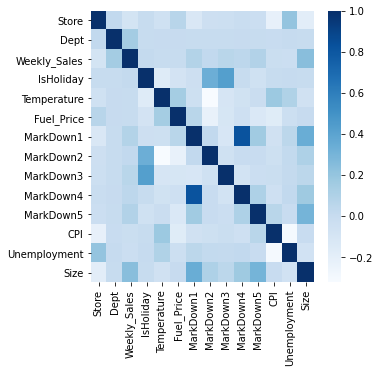

In [6]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(corr_mat,cmap='Blues',annot=False)

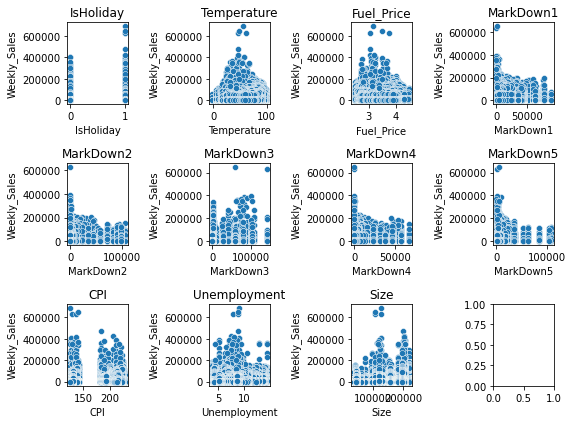

In [7]:
#結構時間かかる
columns = corr_mat.drop(columns=['Store','Dept','Weekly_Sales'],axis=1).columns
n_figs = len(columns)
n_cols = 4
n_rows = math.ceil(n_figs/n_cols)

fig, axes = plt.subplots(figsize=(n_cols * 2, n_rows * 2), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    sns.scatterplot(data=train_feat_df,x=c,y='Weekly_Sales',ax=ax)
    ax.set_title(c)
fig.tight_layout()

## storesに関する考察
- Size
    1. 相関はないが、ノイズとまでは言い切れなさそう。特徴量として追加する
    2. 散布図を見るとbinningしてカテゴリとして扱う方が良いこともわかる。
- Type
    1. Type毎にかなりWeekly_Salesに差があることがわかる。→特徴量として有効

<AxesSubplot:xlabel='Size', ylabel='Weekly_Sales'>

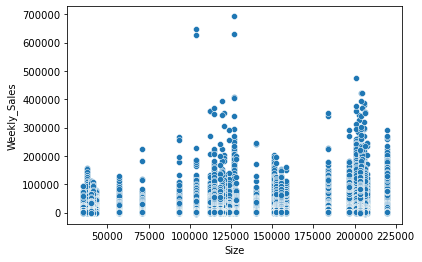

In [8]:
sns.scatterplot(data=train_feat_df,x='Size',y='Weekly_Sales')

<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

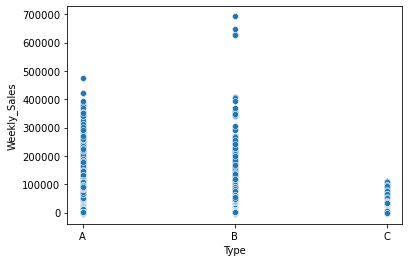

In [9]:
sns.scatterplot(data=train_feat_df,x='Type',y='Weekly_Sales')

## Store、Deptに関する考察
- StoreもDeptもそれぞれに違いはあるが、時系列としての動きはかなり似ている
- Store、Dept毎にかなりWeekly_Salesに差がある
- 各Storeで得意なDeptがある

<AxesSubplot:xlabel='Date', ylabel='Store'>

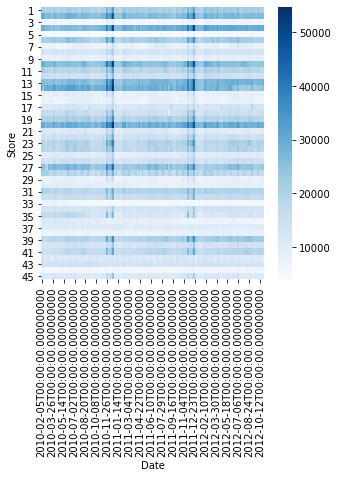

In [11]:
#StoreのDate時系列
pivot_store =  pd.pivot_table(data=train,columns='Date',index='Store',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pivot_store,ax=ax,cmap='Blues')

<AxesSubplot:xlabel='Date', ylabel='Dept'>

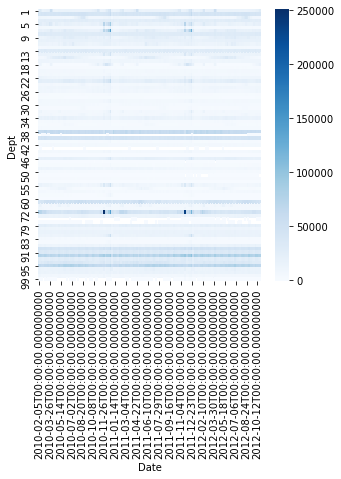

In [12]:
#DeptのDate時系列
pivot_dept =  pd.pivot_table(data=train,columns='Date',index='Dept',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pivot_dept,ax=ax,cmap='Blues')

<AxesSubplot:xlabel='Store', ylabel='Dept'>

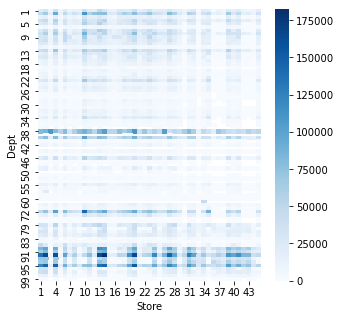

In [14]:
#Store毎に得意なDeptがないか見てみる
pivot_dept_store =  pd.pivot_table(data=train,columns='Store',index='Dept',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pivot_dept_store,ax=ax,cmap='Blues')

<AxesSubplot:xlabel='Month', ylabel='Store'>

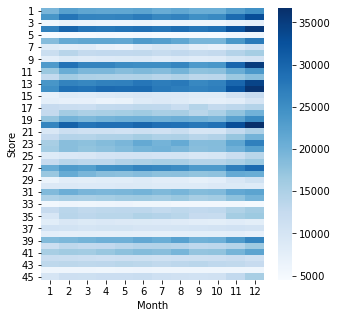

In [16]:
#StoreのMonth時系列
pivot_store =  pd.pivot_table(data=train,columns='Month',index='Store',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pivot_store,ax=ax,cmap='Blues')

<AxesSubplot:xlabel='Month', ylabel='Dept'>

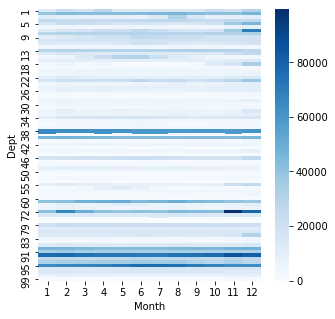

In [17]:
#DeptのMonth時系列
pivot_store =  pd.pivot_table(data=train,columns='Month',index='Dept',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pivot_store,ax=ax,cmap='Blues')

## Weekly_Salesに関する考察
- 一年ごとの相関がかなり高い → 一年前のWeeklySalesを特徴量としてもかなり良い精度が出そう
- IsHolidayは特別な場合にしか関係なさそう

<AxesSubplot:xlabel='Date', ylabel='Weekly_Sales'>

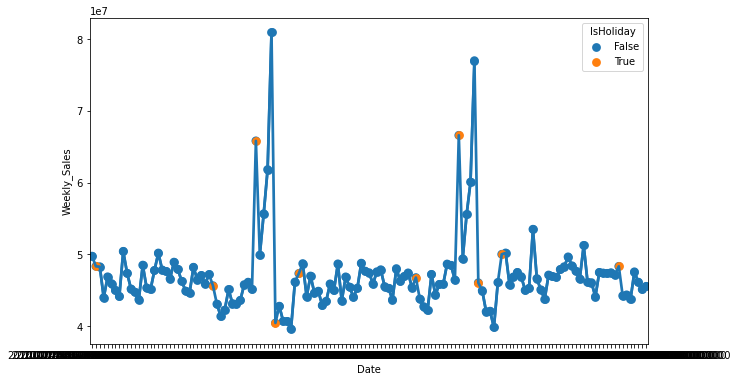

In [18]:
#Weekly_SalesのDate時系列、うまいやり方がわからない。。教えてほしいです。。。
fig, ax = plt.subplots(figsize=(10, 6))
sum_sales = train.groupby('Date')['Weekly_Sales'].sum().reset_index()
sum_sales['IsHoliday'] = train.groupby('Date')['IsHoliday'].mean().reset_index(drop=True)
sns.pointplot(data=sum_sales,x='Date',y='Weekly_Sales',hue='IsHoliday')
sns.pointplot(data=sum_sales,x='Date',y='Weekly_Sales')

Text(0.5, 1.0, 'Compair Weekly_Sales')

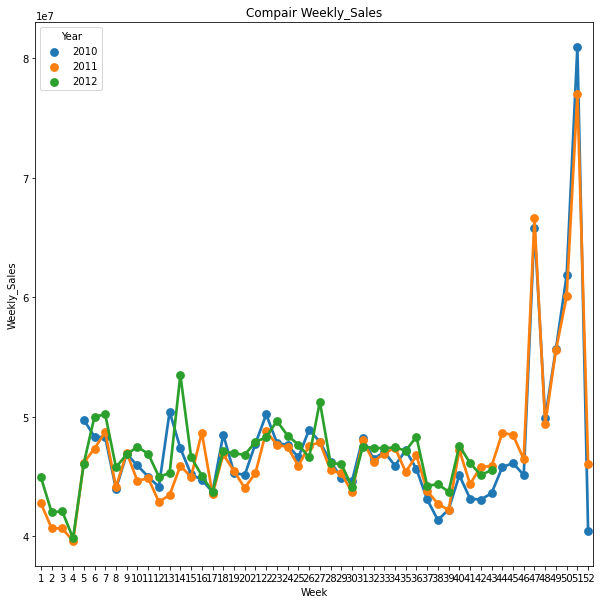

In [19]:
#週ごとの合計時系列
sales = pd.DataFrame(train.groupby(['Year','Week'])['Weekly_Sales'].sum()).reset_index()
fig = plt.figure(figsize=(10,10))
sns.pointplot(data=sales,x='Week',y='Weekly_Sales',hue='Year')
plt.title('Compair Weekly_Sales')

In [20]:
display(pd.pivot_table(sales,index='Week',columns='Year',values='Weekly_Sales').corr())

Year,2010,2011,2012
Year,,,
2010,1.000000,0.952797,0.577703
2011,0.952797,1.000000,0.764723
2012,0.577703,0.764723,1.000000


<StemContainer object of 3 artists>

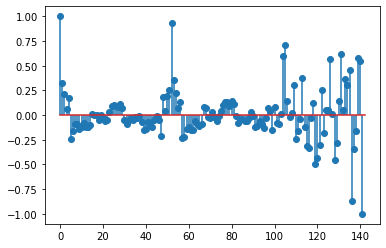

In [47]:
#autocorrs
SalebyDate = train.groupby('Date')['Weekly_Sales'].mean()
lagn = len(SalebyDate)
autocorrs = [SalebyDate.autocorr(lag=lag) for lag in range(lagn)]
plt.stem(range(lagn),autocorrs,use_line_collection=True)

## 分析結果まとめ
- 考察　一年前が大事！！
    - データ量がかなり多い
    - おそらくtrainとtestの分布はかなり似ている(adversal_validationで調べる)
    - 時系列
        - 時系列で見たときの各Store,各Deptの動きは一緒
        - 一年毎の相関がかなり強い
            - 週番号をカテゴリとしてみても
        - 月ごとの関係はそこまで強くなさそう
    - features
        - ほとんど相関が無いのでまずは使わなくて良さそう
    - stores
        - Sizeはbinning,TypeはLabel or OneHot
- Model  
    1.Store,DeptをEmbeddingしてTransformerかLSTM(実装大変、時間かかる、過去の情報を上手く捉えてくれて一番精度が高そう)  
        - トレンドが長いからTransformerのほうが強そう
        - EncoderDecoder?
    2.Dateを何週目という特徴にしてLightGBM(実装楽、時間そこそこ、精度そこそこ,過去の情報がRNNやARMAと比べて上手く使えなさそう？)  
    3.統計モデル(ARMA等)も強そう。(実装が初めて、計算早そう、過去の情報から推測)

- 特徴量 
    - 一年の何週目か
    - 移動平均
    - 自己変化率
    - n期前との差分
    - 月,週ごとのSum_Sales
    - クリスマスとか特別なイベントはフラグ立てる

    - leakが怖いが、そのStore,Deptの一年前のWeekly_Salesをそのまま入れる